In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cmap 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

<p style="font-family:courier;">1. Se cargan los datos de la renta del 2007 y las posiciones geográficas de cada municipio.</p>

In [2]:
data = pd.read_excel('./data/Renta local 2007 FEDEA_16-03-2016.xlsx')
geolocation_data = pd.read_excel('./data/listado-longitud-latitud-municipios-espana.xlsx')

# evita seleccionar filas del formato de la cabecera del excel
columns = data.loc[7].values
data = data.loc[8:].reset_index(drop=True)
data.columns = columns

In [3]:
data.head()

Código INE Comunidad Autónoma  Nombre Comunidad Autónoma  \
0                             01                 Andalucía   
1                             01                 Andalucía   
2                             01                 Andalucía   
3                             01                 Andalucía   
4                             01                 Andalucía   

  Código INE Provincia  Nombre Provincia Código INE municipio  \
0                    04          Almería                 4003   
1                    04          Almería                 4006   
2                    04          Almería                 4013   
3                    04          Almería                 4029   
4                    04          Almería                 4032   

  Código INE municipio (5 dígitos) Nombre municipio  \
0                            04003             Adra   
1                            04006            Albox   
2                            04013          Almería   
3                            04029            Berja   
4                            04032       Carboneras   

  Número de observaciones muestrales Población (INE)  \
0                                970           23742   
1                                418           11166   
2                               7131          186651   
3                                535           14508   
4                                283            7570   

  Población declarante (IRPF)    ...    Índice de Gini   \
0                        8469    ...           0.507839   
1                        3684    ...           0.465912   
2                       77167    ...           0.453057   
3                        4903    ...           0.472552   
4                        2776    ...           0.474658   

  Índice de Atkinson 0,5   Top 1% Top 0,5%  Top 0,1% Quintil 1 Quintil 2  \
0               0.245294  16.6341  13.0227   4.09497     3.049    8.7283   
1               0.200411  8.44044  5.09948  0.874329   2.58415   9.03933   
2               0.190631  10.0338  7.40173   3.49097   3.29687   9.61867   
3               0.210428   11.595  9.08674   3.99979   3.33367    9.3029   
4                0.20316  8.18482  5.38216    1.5088   2.87914   9.08002   

  Quintil 3 Quintil 4 Quintil 5  
0   13.9353   19.6354    54.652  
1   15.7912   22.4131   50.1722  
2   15.1485   22.9598   48.9761  
3    15.106   20.7012   51.5562  
4   14.4229   23.0402   50.5778  

[5 rows x 24 columns]

In [4]:
geolocation_data.head()

Comunidad Provincia  Población   Latitud  Longitud    Altitud  Habitantes  \
0  Andalucía   Almería       Abla  37.14114 -2.780104  871.16840        1504   
1  Andalucía   Almería   Abrucena  37.13305 -2.797098  976.93870        1341   
2  Andalucía   Almería       Adra  36.74807 -3.022522   10.97898       24373   
3  Andalucía   Almería  Albánchez  37.28710 -2.181163  481.31230         815   
4  Andalucía   Almería  Alboloduy  37.03319 -2.621750  388.43460         674   

   Hombres  Mujeres  
0      783      721  
1      682      659  
2    12338    12035  
3      422      393  
4      334      340

<p style="font-family:courier;">2. Limpieza de los datos: Dataset de rentas<p>
<p style="font-family:courier;">2.1. Renombrado de características.<p>

In [5]:
# renombramos columnas para trabajar mas facilmente
name_dict = {u'Código INE Comunidad Autónoma ' : 'ca_ine',
             u'Nombre Comunidad Autónoma' : 'ca_nombre',
             u'Código INE Provincia ' : 'prov_ine',
             u'Nombre Provincia' : 'prov_nombre',
             u'Código INE municipio' : 'mun_ine',
             u'Código INE municipio (5 dígitos)' : 'mun_ine5',
             u'Nombre municipio' : 'mun_nombre',
             u'Número de observaciones muestrales' : 'num_obs_muestrales',
             u'Población (INE)' : 'pob_ine',
             u'Población declarante (IRPF)' : 'pob_declarante_irpf',
             u'Renta imponible agregada (IRPF)' : 'renta_imponible_agregada',
             u'Renta imponible media (por declarante)' : 'renta_imponible_media_declarante',
             u'Renta imponible media (por habitante)' : 'renta_imponible_media_habitante',
             u'Renta mediana' : 'renta_mediana',
             u'Índice de Gini ' : 'gini',
             u'Índice de Atkinson 0,5' : 'atkinson',
             u'Top 1%' : 'top1',
             u'Top 0,5%' : 'top05',
             u'Top 0,1%' : 'top01',
             u'Quintil 1' : 'quintil1',
             u'Quintil 2' : 'quintil2',
             u'Quintil 3' : 'quintil3',
             u'Quintil 4' : 'quintil4',
             u'Quintil 5' : 'quintil5'}

name_geo_dict = {u'Comunidad' : 'ca_nombre',
                 u'Provincia' : 'prov_nombre',
                 u'Población' : 'mun_nombre',
                 u'Latitud' : 'lat',
                 u'Longitud' : 'lon',
                 u'Altitud' : 'alt',
                 u'Habitantes' : 'pob_ine',
                 u'Hombres' : 'mas',
                 u'Mujeres' : 'fem'}

data = data.rename(columns=name_dict)
geolocation_data = geolocation_data.rename(columns=name_geo_dict)

<p style="font-family:courier;">2.2. Comprobación de valores nulos.<p>

In [6]:
data.isnull().sum()

ca_ine                              2
ca_nombre                           2
prov_ine                            0
prov_nombre                         0
mun_ine                             0
mun_ine5                            0
mun_nombre                          0
num_obs_muestrales                  0
pob_ine                             0
pob_declarante_irpf                 0
renta_imponible_agregada            0
renta_imponible_media_declarante    0
renta_imponible_media_habitante     0
renta_mediana                       0
gini                                0
atkinson                            0
top1                                0
top05                               0
top01                               0
quintil1                            0
quintil2                            0
quintil3                            0
quintil4                            0
quintil5                            0
dtype: int64

In [7]:
geolocation_data.isnull().sum()

ca_nombre      0
prov_nombre    0
mun_nombre     0
lat            0
lon            0
alt            0
pob_ine        0
mas            0
fem            0
dtype: int64

<p style="font-family:courier;">2.2.1. Se observa que los 2 valores nulos corresponden a Ceuta y Melilla. Para evitar futuros errores se les asigna como nombre de comunidad autónoma su nombre de provicincia.</p>

In [8]:
data[data.ca_nombre.isnull()]

ca_ine ca_nombre prov_ine prov_nombre mun_ine mun_ine5 mun_nombre  \
1176    NaN       NaN       51       Ceuta   51001    51001      Ceuta   
1177    NaN       NaN       52     Melilla   52001    52001    Melilla   

     num_obs_muestrales pob_ine pob_declarante_irpf   ...         gini  \
1176               5052   76603               24800   ...     0.420734   
1177               4904   69440               23520   ...     0.442504   

      atkinson     top1    top05    top01 quintil1 quintil2 quintil3 quintil4  \
1176  0.163964  8.57578  5.92599  1.89325  4.12885   10.624  15.9148   23.076   
1177  0.182416  8.84367  5.80652  1.90673  3.20896  9.97865  15.6045  23.7852   

     quintil5  
1176  46.2564  
1177  47.4226  

[2 rows x 24 columns]

In [9]:
data.loc[data.prov_nombre == 'Ceuta', 'ca_nombre'] = 'Ceuta'
data.loc[data.prov_nombre == 'Melilla', 'ca_nombre'] = 'Melilla'

data.loc[data.prov_nombre == 'Ceuta', 'ca_ine'] = -1
data.loc[data.prov_nombre == 'Melilla', 'ca_ine'] = -1

<p style="font-family:courier;">2.2.2. Se comprueba que ya no existen valores nulos.<p>

In [10]:
# comprobamos que ya no existe ningun valor nulo en nuestro dataset
existe_nulo = data.isnull().any().any()
print('Existen valores nulos: {}'.format(existe_nulo))

Existen valores nulos: False


<p style="font-family:courier;">2.3. Se eliminan las características redundantes ca_ine y prov_ine, ya que se usará el nombre en su lugar. También se elimina mun_ine porque se usara mun_ine y mun_ine5 porque se usara mun_nombre.</p>

In [11]:
data = data.drop(['ca_ine', 'prov_ine', 'mun_ine', 'mun_ine5'], axis=1)

<p style="font-family:courier;">2.4. En el dataset hay casos en que se asigna el string "n.d." a características numéricas que impiden que su columna correspondiente tome un tipo numérico. Como son pocos casos, se eliminan estas filas.<p>

<p style="font-family:courier;">2.4.1. Casos en los que aparece "n.d." por característica.</p>

In [12]:
(data == 'n.d.').sum()

ca_nombre                           0
prov_nombre                         0
mun_nombre                          0
num_obs_muestrales                  5
pob_ine                             0
pob_declarante_irpf                 0
renta_imponible_agregada            1
renta_imponible_media_declarante    1
renta_imponible_media_habitante     1
renta_mediana                       6
gini                                6
atkinson                            6
top1                                6
top05                               6
top01                               6
quintil1                            6
quintil2                            6
quintil3                            6
quintil4                            6
quintil5                            6
dtype: int64

<p style="font-family:courier;">2.4.2. Se eliminan los casos en los que aparece el valor "n.d." y se convierten al tipo numérico requerido.</p>

In [13]:
filas_incompletas = (data != ('n.d.')).all(axis=1)
data = data.loc[filas_incompletas, :]

for col in data.columns:
    if not 'nombre' in col:
        data[col] = pd.to_numeric(data[col])

<p style="font-family:courier;">3. Limpieza de los datos: Dataset de posiciones geográficas.</p>
<p style="font-family:courier;">3.1. Se modifican los nombres de las comunidades autonomas para poder mezclar estos datos con los de las rentas.</p>

In [14]:
def changeCAName(original):
    if original == u'Asturias': return u'Asturias, Principado de'
    elif original == u'Castilla La Mancha': return u'Castilla-La Mancha'
    elif original == u'Castilla León': return u'Castilla y León'
    elif original == u'Catalunya': return u'Cataluña'
    elif original == u'Valencia': return u'Comunitat Valenciana'
    elif original == u'Madrid': return u'Madrid, Comunidad de'
    elif original == u'Murcia': return u'Murcia, Región de'
    elif original == u'La Rioja': return u'Rioja, La'
    elif original == u'Islas Baleares': return u'Balears, Illes'
    else: return original
    
def changeProvName(original):
    if original == u'Las Palmas': return u'Palmas, Las'
    elif original == u'A Coruña': return u'Coruña, A'
    elif original == u'La Rioja': return u'Rioja, La'
    elif original == u'Illes Balears': return u'Balears, Illes'
    else: return original
    
geolocation_data['ca_nombre'] = geolocation_data['ca_nombre'].apply(changeCAName)
geolocation_data['prov_nombre'] = geolocation_data['prov_nombre'].apply(changeProvName)

<p style="font-family:courier;">3.2. Se cambia el formato del nombre de algunos municipio. Ej.: Ejido (El) => Ejido, El</p>

In [15]:
def changeMunName(original):
    if original[-1:] == ')':
        name = original.split('(');
        original = name[0][:-1] + ', ' + name[1][:-1]
    return original.rstrip()
    
geolocation_data['mun_nombre'] = geolocation_data['mun_nombre'].apply(changeMunName)
data['mun_nombre'] = data['mun_nombre'].apply(changeMunName)
data['prov_nombre'] = data['prov_nombre'].apply(changeMunName)

<p style="font-family:courier;">3.3. Se mezclan ambos datasets.</p>

In [16]:
geolocation_data = geolocation_data[['ca_nombre', 'prov_nombre', 'mun_nombre', 'lat', 'lon']]

data = pd.merge(data, geolocation_data, on=['ca_nombre', 'prov_nombre', 'mun_nombre'], how='left')
data.head()

ca_nombre prov_nombre  mun_nombre  num_obs_muestrales  pob_ine  \
0  Andalucía     Almería        Adra                 970    23742   
1  Andalucía     Almería       Albox                 418    11166   
2  Andalucía     Almería     Almería                7131   186651   
3  Andalucía     Almería       Berja                 535    14508   
4  Andalucía     Almería  Carboneras                 283     7570   

   pob_declarante_irpf  renta_imponible_agregada  \
0                 8469              1.301441e+08   
1                 3684              5.431214e+07   
2                77167              1.595269e+09   
3                 4903              7.392175e+07   
4                 2776              5.365650e+07   

   renta_imponible_media_declarante  renta_imponible_media_habitante  \
0                          15367.12                      5481.599666   
1                          14742.71                      4864.064449   
2                          20672.94                      8546.799969   
3                          15076.84                      5095.240317   
4                          19328.71                      7088.044777   

   renta_mediana    ...          top1      top05     top01  quintil1  \
0       10929.20    ...     16.634070  13.022720  4.094971  3.048995   
1       11466.70    ...      8.440436   5.099482  0.874329  2.584146   
2       15608.84    ...     10.033810   7.401731  3.490967  3.296872   
3       11233.35    ...     11.595000   9.086736  3.999785  3.333673   
4       14443.65    ...      8.184823   5.382164  1.508799  2.879141   

   quintil2  quintil3  quintil4  quintil5       lat       lon  
0  8.728300  13.93528  19.63541  54.65202  36.74807 -3.022522  
1  9.039330  15.79120  22.41311  50.17221  37.38979 -2.147483  
2  9.618672  15.14850  22.95985  48.97610  36.84016 -2.467922  
3  9.302896  15.10602  20.70120  51.55621  36.84644 -2.949425  
4  9.080024  14.42285  23.04019  50.57779  36.99659 -1.895012  

[5 rows x 22 columns]

<p style="font-family:courier;">4. Exploración del dataset </p>

<p style="font-family:courier;">4.1. Distribución de la renta media por habitante.</p>

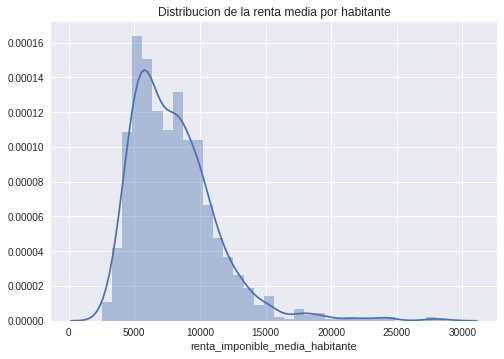

In [17]:
sns.distplot(data['renta_imponible_media_habitante'])
plt.title('Distribucion de la renta media por habitante')
plt.show()

<p style="font-family:courier;">Se observa que la renta media por habitante en la mayoría de los municipios se encuentra en el intervalo 5000 - 10000€. Por otro lado, son muy pocos los municipios con una renta media por habitante superior a los 25000€.</p>

<p style="font-family:courier;">Los 10 municipios con una renta media más alta se encuentran en las comunidades autónomas de Cataluña y en Madrid.</p>

In [18]:
data[data.renta_imponible_media_habitante.rank(method='first', ascending=False) <= 10]

ca_nombre prov_nombre             mun_nombre  \
550               Cataluña   Barcelona                 Alella   
563               Cataluña   Barcelona                Cabrils   
599               Cataluña   Barcelona             Matadepera   
633               Cataluña   Barcelona  Sant Cugat del Vallès   
641               Cataluña   Barcelona      Sant Just Desvern   
660               Cataluña   Barcelona                   Teià   
1059  Madrid, Comunidad de      Madrid     Boadilla del Monte   
1097  Madrid, Comunidad de      Madrid  Paracuellos de Jarama   
1100  Madrid, Comunidad de      Madrid     Pozuelo de Alarcón   
1102  Madrid, Comunidad de      Madrid   Rozas de Madrid, Las   

      num_obs_muestrales  pob_ine  pob_declarante_irpf  \
550                  306     8998                 4492   
563                  235     6698                 3249   
599                  331     8266                 4070   
633                 2475    74345                36136   
641                  501    15391                 7736   
660                  176     5969                 2917   
1059                1151    39791                20111   
1097                 333     8572                 6597   
1100                3120    79826                38373   
1102                1168    79876                41305   

      renta_imponible_agregada  renta_imponible_media_declarante  \
550               1.943485e+08                          43265.47   
563               1.485308e+08                          45715.86   
599               2.376075e+08                          58380.21   
633               1.822497e+09                          50434.39   
641               4.251205e+08                          54953.53   
660               1.424362e+08                          48829.70   
1059              9.701880e+08                          48241.66   
1097              2.048633e+08                          31054.01   
1100              2.222469e+09                          57917.53   
1102              1.827723e+09                          44249.44   

      renta_imponible_media_habitante  renta_mediana    ...          top1  \
550                      21599.076599       27831.08    ...     14.508090   
563                      22175.399991       25560.70    ...     23.985400   
599                      28745.155420       33180.83    ...     18.595600   
633                      24514.050939       30533.88    ...     21.007460   
641                      27621.370157       39094.06    ...     23.403990   
660                      23862.662908       23034.60    ...     19.399370   
1059                     24382.097064       30953.81    ...     21.378320   
1097                     23899.125521       25624.39    ...      6.943627   
1100                     27841.422327       28358.97    ...     21.725890   
1102                     22882.006099       25199.20    ...     14.006860   

          top05      top01  quintil1   quintil2   quintil3  quintil4  \
550    9.953933   3.428857  2.516341   7.426208  11.512700  22.92688   
563   19.700610   6.786305  3.685803  10.194370  11.991850  13.33469   
599   13.790760   6.232959  4.178130   8.044644  10.859700  16.18075   
633   17.409510  11.384780  2.885392   7.939102  12.001800  18.41735   
641   19.605400  15.098110  1.419579   6.715751  12.704330  17.14588   
660    9.365215   1.337888  2.295723   6.248680   8.701299  12.22219   
1059  17.492670   6.378783  4.198931   8.982224  13.044290  18.29195   
1097   4.108325   1.122859  3.230592  10.471310  16.238340  23.84840   
1100  16.369660   7.011314  2.995078   7.035832  10.011850  16.30652   
1102   9.823323   3.812657  3.511692   8.233363  11.710200  20.11903   

      quintil5       lat       lon  
550   55.61787  41.49395  2.295461  
563   60.79329  41.52552  2.368645  
599   60.73678  41.59670  2.026747  
633   58.75635  41.47186  2.082139  
641   62.01447  41.38576  2.075544  
660   70.53210  41.49969  2.320616  
1059  55.4826

<p style="font-family:courier;">Por otro lado, los 10 municipios con una renta media por habitante más baja se encuentran repartidos en Andalucía, Canarias, Valencia y Galicia.</p>

In [19]:
data[data.renta_imponible_media_habitante.rank(method='first') <= 10]

ca_nombre             prov_nombre  \
42               Andalucía                   Cádiz   
204              Andalucía                 Sevilla   
252              Andalucía                 Sevilla   
378               Canarias  Santa Cruz de Tenerife   
401               Canarias  Santa Cruz de Tenerife   
405               Canarias  Santa Cruz de Tenerife   
407               Canarias  Santa Cruz de Tenerife   
794   Comunitat Valenciana        Alicante/Alacant   
795   Comunitat Valenciana        Alicante/Alacant   
1017               Galicia              Pontevedra   

                      mun_nombre  num_obs_muestrales  pob_ine  \
42                Puerto Serrano                 264     7005   
204                  Campana, La                 114     5310   
252   Villanueva del Río y Minas                  79     5229   
378         Buenavista del Norte                 179     5188   
401           Santiago del Teide                 155    11493   
405                    Tazacorte                 167     5828   
407               Valle Gran Rey                 115     5116   
794                      Rojales                 315    17543   
795                San Fulgencio                 224    10583   
1017                   Cañiza, A                 208     6696   

      pob_declarante_irpf  renta_imponible_agregada  \
42                   2229               21465871.83   
204                  1455               16907536.50   
252                  1203               16787973.27   
378                  1482               16731113.10   
401                  2273               33008051.40   
405                  1531               17095253.17   
407                  1123               14145611.21   
794                  4003               54302976.71   
795                  2304               26751997.44   
1017                 1702               20963261.68   

      renta_imponible_media_declarante  renta_imponible_media_habitante  \
42                             9630.27                      3064.364287   
204                           11620.30                      3184.093503   
252                           13955.09                      3210.551400   
378                           11289.55                      3224.963975   
401                           14521.80                      2872.013521   
405                           11166.07                      2933.296700   
407                           12596.27                      2764.974826   
794                           13565.57                      3095.421348   
795                           11611.11                      2527.827406   
1017                          12316.84                      3130.714110   

      renta_mediana    ...          top1     top05     top01  quintil1  \
42          8055.43    ...      3.507806  2.065704  0.612239  3.124916   
204         9102.53    ...      5.323068  3.150561  0.816707  3.190985   
252        10118.61    ...      4.910100  2.578565  0.429761  3.165182   
378         9592.92    ...      6.056565  3.189212  0.455602  4.328319   
401        11018.73    ...      7.892269  5.235999  1.142271  3.830173   
405         9230.32    ...      2.527823  1.179651  0.168521  5.272364   
407        10560.41    ...      7.839111  5.235197  1.176644  3.330013   
794        10584.79    ...      9.819536  6.331457  2.633833  2.472454   
795         7490.79    ...      8.974784  4.292288  0.780416  1.598176   
1017       11071.52    ...      5.016288  3.671761  0.518894  3.708099   

       quintil2  quintil3  quintil4  quintil5       lat        lon  
42    10.793720  18.11690  26.32420  41.64026  36.92159  -5.545621  
204    9.771632  15.45837  21.26569  50.31332  37.56945  -5.425768  
252   10.963290  15.54445  25.70344  44.62365  37.66010  -5.714389  
378   11.002690  16.36131  23.33351  44.97417  28.37029 -16.850240  
401   10.199580  14.89077  20.07496  51.00452  28.29614 -16.814610  
405   10.986930  16.25059  23.47414  44.01598

<p style="font-family:courier;">4.2. Distribución de la renta media por habitante en cada comunidad autónoma.</p>

<p style="font-family:courier;">Se observa que la comunidad autónomas con municios con rentas más altas son Cataluña y Madrid. </p>

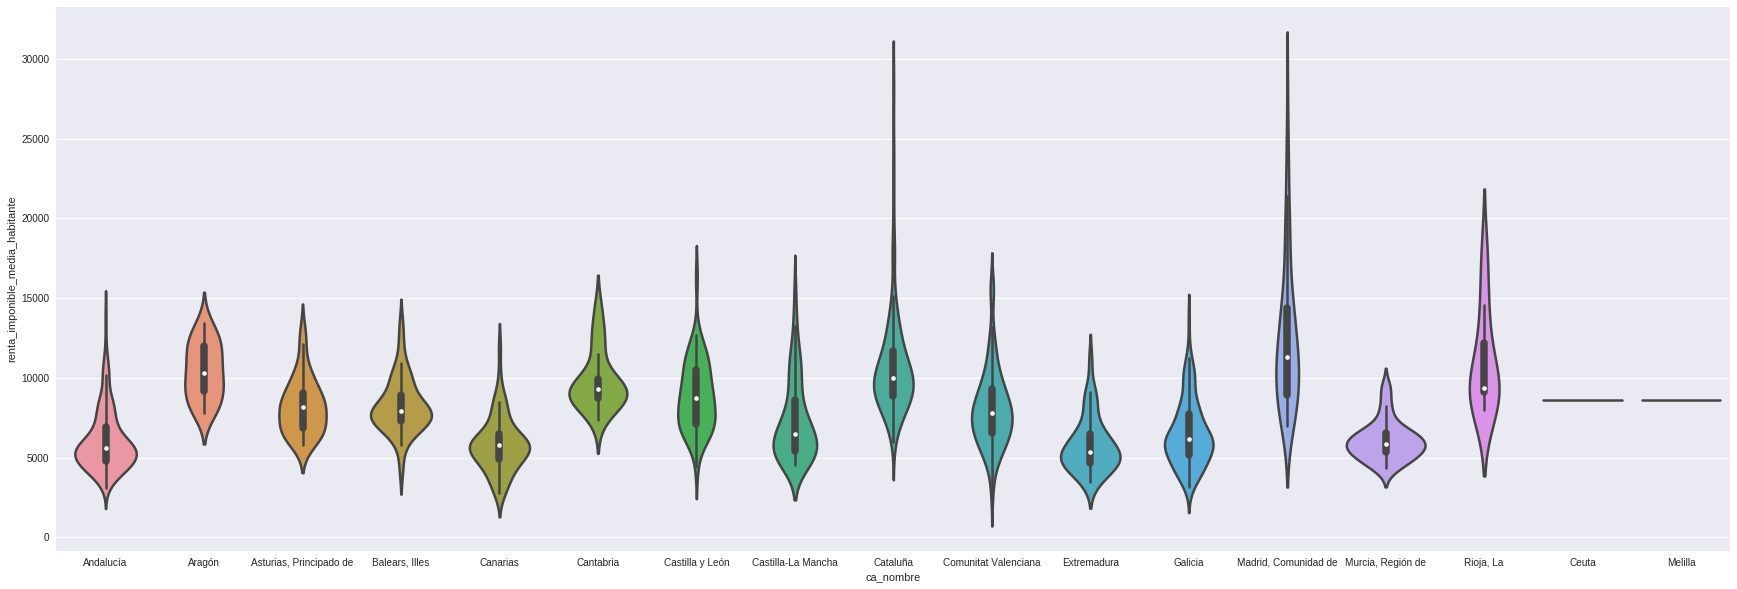

In [20]:
plt.figure(figsize=(30, 10))
sns.violinplot(x='ca_nombre', y='renta_imponible_media_habitante', data=data, linewidth=2.5)
plt.show()

<p style="font-family:courier;">4.3. Distribución de la renta media por habitante en el mapa. Se observa que las más altas (colores más rojos) se encuentran en la parte norte y noreste de la pensinsula.</p>

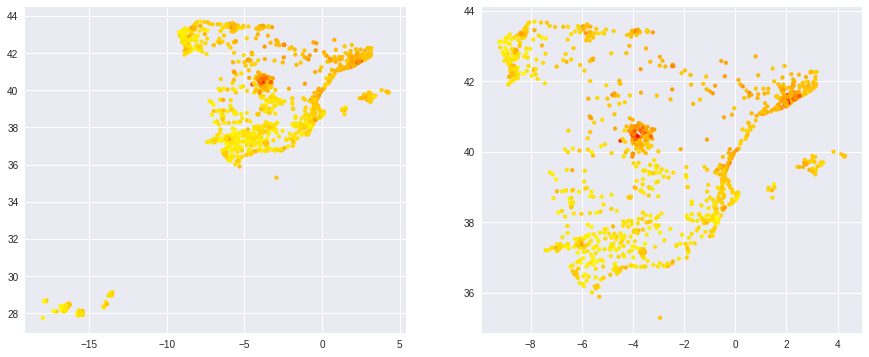

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((15, 6))

ax1.scatter(data.lon, data.lat, s=15, c=data.renta_imponible_media_habitante, cmap=cmap.autumn_r)

mask_peninsula = (data.lon > -10) & (data.lat > 34)
location_peninsula = data.loc[mask_peninsula, ['lon', 'lat']]
renta_media = data.loc[mask_peninsula, 'renta_imponible_media_habitante']

ax2.scatter(location_peninsula.lon, location_peninsula.lat, c=renta_media, s=15, cmap=cmap.autumn_r)
plt.savefig('graficos/distribucion_renta_geo.svg', bbox_inches='tight')
plt.savefig('graficos/distribucion_renta_geo.jpg', bbox_inches='tight')
plt.show()

<p style="font-family:courier;">5. Extracción y selección de características.</p>

<p style="font-family:courier;">5.1. Se crea la característica de distancia Euclídea de cada municipio a Madrid.</p>

<p style="font-family:courier;">Tal y como se observa, los municipios con las rentas más altas se encuentran o en el centro o en el borde de la peninsula. Para pintar este gráfico se han eliminado los municipios pertenecientes a las Islas Canarias. </p>

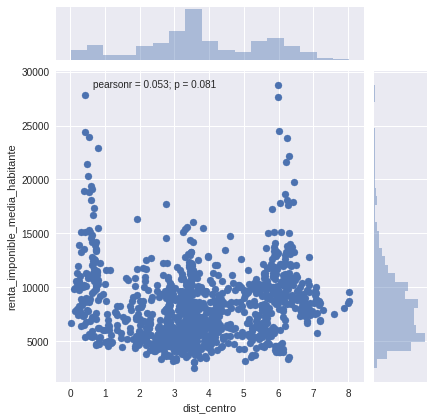

In [22]:
lat_centro, lon_centro = 40, -3.75
data['dist_centro'] = np.sqrt((data.lat - lat_centro)**2  + (data.lon - lon_centro)**2)
data_sin_canarias = data.loc[data.dist_centro < 10, ['dist_centro', 'renta_imponible_media_habitante']]

sns.jointplot(data_sin_canarias.dist_centro, data_sin_canarias.renta_imponible_media_habitante)
plt.show()

<p style="font-family:courier;">5.3. Correlación entre características. Con el fin de filtrar aquellas características redundantes se calcula la matriz de correlación entre las características.</p>

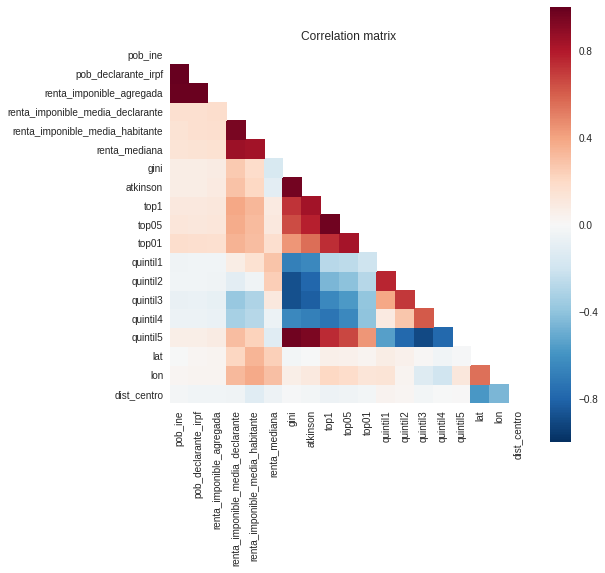

In [23]:
def plot_correlation_map(df):
    corr_matrix = df.corr(method='pearson')
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.title('Correlation matrix')
        sns.heatmap(corr_matrix, square=True, mask=mask)
        plt.show()


features_categorical = ['ca_nombre', 'prov_nombre', 'mun_nombre', 'mun_ine5']
features_selection = [f for f in data.columns if f not in features_categorical and f != 'num_obs_muestrales']

data_numeric = data[features_selection]

plot_correlation_map(data_numeric)

<p style="font-family:courier;">Algunas características presentan unas correlaciones muy altas y por tanto conviene eliminar aquellas que sean redundantes:<p>

<p style="font-family:courier;"><b>pob_ine, pob_declarante_irpf y renta_imponible_agregada</b>

<br>
<p style="font-family:courier;">Las características pob_ine (población del municipio), pob_declarante_irpf (población que realiza la declaración) y renta_imponible_agregada presentan una correlación directa alta. Esto es lógico debido a que ambas características toman valores más altos conforme aumenta la población del municipio.</p>

<p style="font-family:courier;">Se decide eliminar las características pob_ine y pob_declarante_irpf, y conservar renta_imponible_agregada. Además, se extrae la característica de proporción de la población del municipio que realiza la declaración de la renta, que captura información de las características eliminadas y tiene un índice de correlación cercano a 0 con renta_imponible_agregada.</p>

In [24]:
# prop_declarantes
data_numeric['prop_declarantes'] = data.pob_declarante_irpf / data.pob_ine
data_selection = data_numeric.drop(['pob_ine', 'pob_declarante_irpf'], axis=1)

<p style="font-family:courier;"><b>renta_mediana, renta_imponible_media_habitante y renta_imponible_media_declarante</b><p>

<p style="font-family:courier;">Se conserva renta_imponible_media_declarante debido a la correlación cercana a 1. Además, parte de la información contenida en la característica renta_imponible_media_habitante es capturada por la característica extraída prop_declarantes, tal y como se muestra a continuación:</p>

In [25]:
pr_dec = scipy.stats.pearsonr(data_numeric.prop_declarantes, data_numeric.renta_imponible_media_declarante)[0]
pr_hab = scipy.stats.pearsonr(data_numeric.prop_declarantes, data_numeric.renta_imponible_media_habitante)[0]

print('Coeficiente de Pearson [prop_declarantes, renta_imponible_media_declarante]: {}'.format(round(pr_dec, 3)))
print('Coeficiente de Pearson [prop_declarantes, renta_imponible_media_habitante]: {}'.format(round(pr_hab, 3)))

Coeficiente de Pearson [prop_declarantes, renta_imponible_media_declarante]: 0.494
Coeficiente de Pearson [prop_declarantes, renta_imponible_media_habitante]: 0.734


<p style="font-family:courier;"><b>gini, atkinson y quintil5</b><p>

<p style="font-family:courier;">Los coeficientes de Gini y Atkinson son utilizados para medir la desigualdad de ingresos, luego es lógico que su correlación sea muy alta. Además la característica quintil5 presenta una correlación muy alta con estos índices. Por tanto, solo se decide conservar el coeficiente de Gini.</p>


<p style="font-family:courier;"><b>top1, top05 y top01</b><p>

<p style="font-family:courier;">Se eliminan debido a su alta correlación con gini </p>

<p style="font-family:courier;"><b>quintiles</b><p>

<p style="font-family:courier;">Debido a que quintil2 esta correlacionado con quintil1 y quintil3 con quintil4, y el quintil 3 esta correlacionado con el índice de gini, se decide conservar tan solo quintil1.</p>

<p style="font-family:courier;"><b>lat y lon</b><p>

<p style="font-family:courier;">Como se desea buscar patrones relacionados con la renta y no con la localización geográfica, se eliminan las características lat, lon y la distancia al centro.</p>

In [26]:
data_selection = data_selection.drop(['renta_imponible_media_habitante', 'quintil2', 'quintil3', 'quintil4',\
                                      'quintil5', 'atkinson', 'top1', 'top05', 'top01', 'renta_mediana', 'lat', \
                                      'lon', 'dist_centro'], axis=1)

<p style="font-family:courier;">Tal y como se observa, en la matriz de correlación ya no hay características redundantes (cercanas a un coeficiente de Pearson de 1 o -1).<p>

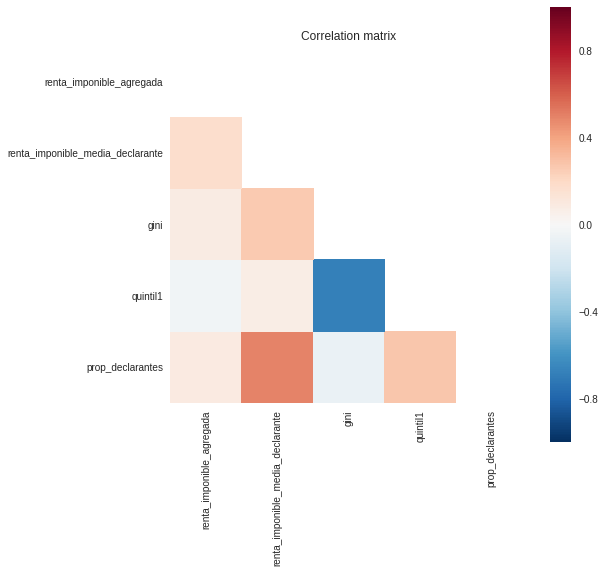

In [27]:
plot_correlation_map(data_selection)

<p style="font-family:courier;">6. Escalado de características.<p>

In [28]:
data_selection.describe()

renta_imponible_agregada  renta_imponible_media_declarante  \
count              1.172000e+03                       1172.000000   
mean               3.086097e+08                      18395.543976   
std                1.655970e+09                       5589.513617   
min                1.414561e+07                       9322.090000   
25%                5.076502e+07                      14853.250000   
50%                9.185201e+07                      17461.695000   
75%                1.905751e+08                      20499.937500   
max                4.734121e+10                      58380.210000   

              gini     quintil1  prop_declarantes  
count  1172.000000  1172.000000       1172.000000  
mean      0.448717     3.658750          0.427795  
std       0.049765     0.760394          0.067719  
min       0.262859     1.419579          0.197773  
25%       0.418093     3.182097          0.381797  
50%       0.448121     3.588293          0.428372  
75%       0.476554     4.026930          0.477707  
max       0.658847     7.475212          0.769599

<p style="font-family:courier;">6.1. Transformación logarítmica a la característica renta_imponible_agregada debido a que toma valores muy extremos.</p>

In [29]:
data_selection['renta_imponible_agregada'] = np.log(data_selection.renta_imponible_agregada)

<p style="font-family:courier;">6.2. Escalado entre 0 y 1. Después se centran los datos restando la media de cada característica.

In [30]:
data_selection[:] = MinMaxScaler().fit_transform(data_selection[:])
data_selection -= data_selection.mean(axis=0)

<p style="font-family:courier;">7. Se guardan los datos limpios preparados para aplicar el algoritmo de clustering.<p>

In [31]:
data_selection.to_csv('./data/data_cleaned.csv', index=False)

<p style="font-family:courier;">8. Carga los resultados del clustering (tras ejecución de script "clustering.R").<p>

In [32]:
grupos = pd.read_csv('./data/grupos.csv', header=None)
grupos.columns = ['grupo']
data = pd.concat([data, grupos], axis=1)

<p style="font-family:courier;">8.1. Grupo con gran desigualdad de municipios ricos.<p>

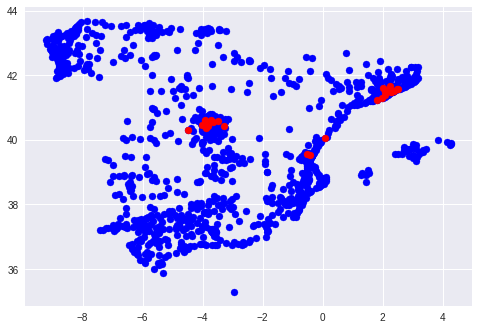

In [33]:
data_peninsula = data[mask_peninsula]
location_g1 = data_peninsula.loc[(data.grupo == 21) | (data_peninsula.grupo == 22), ['lon', 'lat']]

plt.scatter(data_peninsula.lon, data_peninsula.lat, c='b')
plt.scatter(location_g1.lon, location_g1.lat, c='r')
plt.show()

<p style="font-family:courier;">8.2. Grupo con gran desigualdad de municipios pobres.<p>

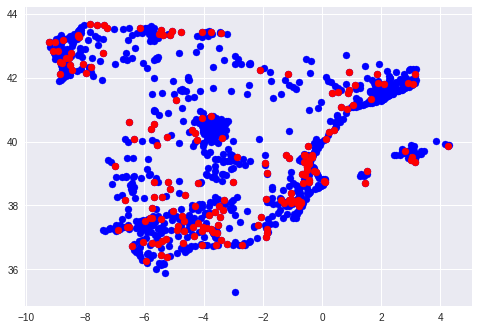

In [34]:
location_g2 = data_peninsula.loc[(data.grupo == 19) | (data_peninsula.grupo == 20) 
                          | (data_peninsula.grupo == 24) | (data_peninsula.grupo == 25), ['lon', 'lat']]

plt.scatter(data_peninsula.lon, data_peninsula.lat, c='b')
plt.scatter(location_g2.lon, location_g2.lat, c='r')
plt.show()

<p style="font-family:courier;">8.3. Grupo de desigualdad media de municipios grandes.<p>

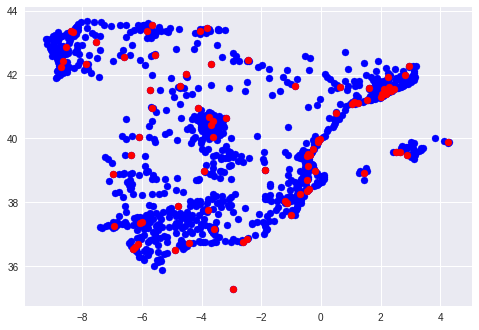

In [35]:
location_g3 = data_peninsula.loc[(data.grupo == 16) | (data_peninsula.grupo == 17), ['lon', 'lat']]

plt.scatter(data_peninsula.lon, data_peninsula.lat, c='b')
plt.scatter(location_g3.lon, location_g3.lat, c='r')
plt.show()

<p style="font-family:courier;">8.4. Grupo de municipios con una renta baja y pero muy equilibrada.<p>

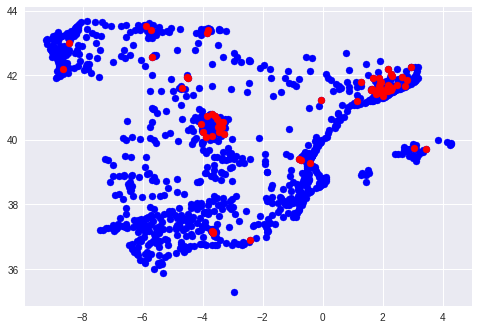

In [36]:
location_g4 = data_peninsula.loc[(data.grupo == 1) | (data_peninsula.grupo == 2), ['lon', 'lat']]

plt.scatter(data_peninsula.lon, data_peninsula.lat, c='b')
plt.scatter(location_g4.lon, location_g4.lat, c='r')
plt.show()

<p style="font-family:courier;">8.5. Grupo de municipios pequeños y con renta equilibrada.<p>

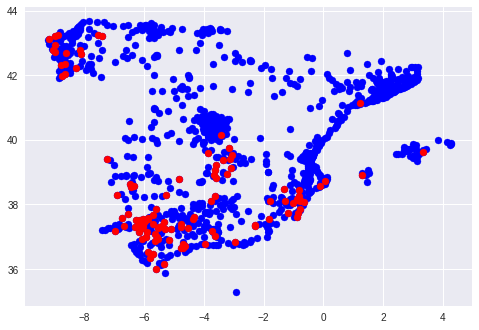

In [37]:
location_g5 = data_peninsula.loc[(data.grupo == 3) | (data_peninsula.grupo == 4) 
                                 | (data.grupo == 5), ['lon', 'lat']]

plt.scatter(data_peninsula.lon, data_peninsula.lat, c='b')
plt.scatter(location_g5.lon, location_g5.lat, c='r')

plt.savefig('graficos/g5.svg', bbox_inches='tight')
plt.savefig('graficos/g5.jpg', bbox_inches='tight')
plt.show()